# 패키지

In [34]:
# !pip install seaborn
# !pip install tqdm
# !pip install -U scikit-learn
# !pip install emoji
# !pip install pyarrow
# !pip install fastparquet
# !pip install squarify
# !pip install wordcloud

In [2]:
# library
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import re
import squarify
from tqdm import tqdm, tqdm_pandas
import nltk
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import CountVectorizer
from konlpy.tag import Kkma, Hannanum
from collections import Counter
from emoji import core
from wordcloud import WordCloud
from matplotlib import font_manager, rc

font_path = "C:/Windows/Fonts/malgun.ttf"
font = font_manager.FontProperties(fname=font_path).get_name()
rc('font', family=font)

nltk.download('punkt')
nltk.download('stopwords')
nltk.download('wordnet')

Kkma = Kkma()
hannanum = Hannanum()

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\user\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


-----------------------
# 함수

In [48]:
# dataframe에 있는 contents(본문)에 키워드 존재 여부 칼럼만들기
def keyword_search(df, key1):

    key1_list = []
    key2_list = []

    for i in df['contents']:
        if '아이스크림' in i:
            key1_list.append(True)

        else:
            key1_list.append(False)

    df[key1] = key1_list
    return df

# 전처리 함수 1 : point_reduce
# 점이 여러개 찍혀있는 것을 한개로 바꿈

def point_reduce(sentence):
    while True:
        try:
            if '..' in sentence:
                sentence = sentence.replace('..','.')
            
            else:
                sentence = sentence.replace('.','. ') # 온점 뒤에 space 넣어뒀음. 불필요시 제거.
                if '  ' in sentence:
                    sentence = sentence.replace('  ',' ')
                    # print(sentence)
                    return sentence
                    break
                else:
                    return sentence
        except:
            return sentence
        
        # if '  ' not in sentence:
        #     break

# 문장 단위로 끊기
def classify_sentence(sentence):
    sentence_list = sentence.split('. ')
    if ' ' in sentence_list:
        sentence_list.remove(' ')
        return sentence_list

    else:
        return sentence_list

# dummy 없애기 (밀크티 관련만 남기기)

def search_milkT(text):
    if "밀크티" in text:
        return True

    elif "밀크t" in text.lower():
        return True
            
    elif "milkT" in text.lower():
        return True
    
    elif "ㅁㅋㅌ" in text:
        return True

    # elif "학습" in text:
    #     return True

    else:
        return False

# 광고 여부 확인하기

def check_ad(text):
    if '광고' in text:
        return True
    
    elif '추천인' in text:
        return True

    elif '서포터' in text:
        return True

    else:
        return False

# 주어 찾기 함수

def subject_extraction(text):
    
    # 형태소 분석
    pos = Kkma.pos(text)

    # 주어 추출
    for i in range(len(pos)):
        if pos[i][1] == 'NNG':  # 명사
            if i == 0 or (i > 0 and pos[i-1][1] != 'NNG'):  # 주어는 문장 첫 단어이거나 앞 단어가 조사가 아닌 경우
                return pos[i][0]
                break

# 키워드가 주어인 본문 정리하기
## keword에서 다음 keyword 까지의 text 추출


def gather_sentence(text, key1, key2):
    
    text_list = text.split('.') # 문장 단위 : "."

    while ' ' in text_list: # '' 안에 text가 들어있지 않으면 error가 발생함을 방지
        text_list.remove(' ')

    key1_paragraph = []
    key2_paragraph = []
    for i in range(len(text_list)):
        if subject_extraction(text_list[i]) == key1:
            plus_num = 1
            # milk_para.append(text_list[i])
            sentence = text_list[i]
            # print(f'{key1}파트 {i}번째 진행중')
            while i+plus_num < len(text_list):
                if subject_extraction(text_list[i+plus_num]) == key1 or subject_extraction(text_list[i+plus_num]) == key2:
                    # print(f'!! 스캔 {key1}파트 종료')
                    break
                
                else:
                    # milk_para.append(text_list[i+plus_num])
                    if i+plus_num > len(text_list):
                        # print(f'!! 스캔 {key1}파트 종료')
                        break
                    else:
                        sentence = sentence + '' + text_list[i+plus_num]
                        plus_num += 1
                        # print(f'!! 스캔 {key1}파트 {i+plus_num}번째 진행중')

            key1_paragraph.append(sentence)

        else:
            pass

        if subject_extraction(text_list[i]) == key2:
            plus_num = 1
            # milk_para.append(text_list[i])
            sentence = text_list[i]
            # print(f'{key2}파트 {i}번째 진행중')
            while i+plus_num < len(text_list):
                if subject_extraction(text_list[i+plus_num]) == key1 or subject_extraction(text_list[i+plus_num]) == key2:
                    break
                
                else:
                    # milk_para.append(text_list[i+plus_num])
                    sentence = sentence + '' + text_list[i+plus_num]
                    plus_num += 1

            key2_paragraph.append(sentence)

        else:
            pass

    if key1_paragraph == []:
        for i in range(len(text_list)):
            pos_list = Kkma.pos(text_list[i])
            if (key1, 'NNG') in pos_list:
                key1_paragraph.append(text_list[i])

    if key2_paragraph == []:
        for i in range(len(text_list)):
            pos_list = Kkma.pos(text_list[i])
            if (key2, 'NNG') in pos_list:
                key2_paragraph.append(text_list[i])
    else:
        pass
    
    return {key1 : key1_paragraph, key2 : key2_paragraph}

# 명사, 동사 추출

def extract_func(dict):
    key1 = list(dict.keys())[0]
    key2 = list(dict.keys())[1]
    key1_list = []
    key2_list = []

    for i in range(len(dict[key1])):
        pos = Kkma.pos(dict[key1][i])
        for j in pos:
            if j[1] == 'VA': #동사
                if j[1] not in stop_words:
                    key1_list.append(j[0]+'다')
            if j[1] == 'NNG':
                if j[1] not in stop_words:
                    key1_list.append(j[0])

    for i in range(len(dict[key2])):
        pos = Kkma.pos(dict[key2][i])
        for j in pos:
            if j[1] == 'VA': #동사
                if j[1] not in stop_words:
                    key2_list.append(j[0]+'다')
            if j[1] == 'NNG':
                if j[1] not in stop_words:
                    key2_list.append(j[0])

    frequncy_dict = {key1 : key1_list, key2 : key2_list}

    return frequncy_dict

-------------------------
# 코드

In [5]:
    # dataframe 불러오기 및 전처리
df_mg = pd.DataFrame(columns=['contents', 'recommend', '아이스크림', '엘리하이', 'keyword_dict']) # 'topic'

for i in tqdm(range(1,6)):
        # csv파일 불러오기
        df = pd.read_parquet(f'./data/crwaling_data{i}.parquet') 
        df.rename(columns={'text' : 'contents'}, inplace=True)
        # 크롤링 실패한 raw, 불필요한 column 삭제
        col_list = list(df.columns)
        col_list.remove('contents')
        df.drop(col_list, axis=1, inplace=True)

        # 정규식
        df.contents = df.contents.apply(lambda x : re.sub('[-=+,#/\?:^$@*\"※~&%ㆍ!』\\‘|\(\)\[\]\<\>`\'…》\n★▲;]','', x))
        df.contents = df.contents.apply(lambda x : re.sub('\W. ','',x))

        # 이모티콘 제거
        df.contents = df.contents.apply(lambda x : core.replace_emoji(x, replace=''))

        # 문장단위로 분리
        df['contents'] = df['contents'].apply(lambda x: point_reduce(x))
        df['contents_list'] = df['contents'].apply(lambda x: classify_sentence(x))

        # dummy 없애기 2 (학습과 관련된 데이터만 남기기 ('학습', '선생'))

        df['Check_milkT'] = df['contents'].apply(lambda x : search_milkT(x))
        df['check_test'] = df['contents'].apply(lambda x : '학습' in x and '선생' in x)

        # df.Check_milkT.value_counts()
        # df['check_test'].value_counts()

        df = df[df['check_test'] == True]
        df = df[df['Check_milkT'] == True]

        df['recommend'] = df['contents'].apply(lambda x : check_ad(x))
        df = df.drop(['Check_milkT', 'check_test'], axis=1)
        df.reset_index(drop=True, inplace=True)

        df.drop('contents_list', axis=1, inplace=True)
        df = keyword_search(df, '아이스크림')
        df = keyword_search(df, '엘리하이')   

        df_mg = pd.merge(df_mg, df, how='outer')

100%|██████████| 5/5 [00:03<00:00,  1.32it/s]


In [50]:
stop_words = ['아이', '맘', '거', '저', '저희', '것', '학모', '감사', '게', '때', '애', '원', '제', '개', '일', '듯', '만', '번', '데', '분', '건', '정도', '달', '정보', '이번', '부탁', '걸로', '후', '나', '부분', '걸', '저흰', '답변', '마음', '뼈', '건가요', '오늘', '왜', '시', '꺼', '친구', '마미', '때문', '하루', '명', '돈', '해요', '이', '가요', '기', '지금', '건가요', '반', '주세요', '편', '외', '소개', '입니다', '곳', '이거', '뭐', '땐', '건지', '그거', '점', '땐', '미', '풀', '대', '안', '눈', '공주', '사', '오', '백', '후', '나']

In [6]:
df_mg

,keyword_dict,contents,recommend,아이스크림,엘리하이
0,NaN,아이스크림홈런 천재교육밀크티 밀크T 밀크티 초등학습지 유아학습지 학습지선택 학습기 ...,False,True,True
1,NaN,우리카드 9월 이벤트 밀크T 무료체험하고 혜택 100 받기■ 밀크T 무료 체험 이벤...,True,True,True
2,NaN,곧 초등학교에 입학하는 첫째에게시켜준없었어서방학기간에 초등학교 입학 준비를 시켜주기...,False,True,True
3,NaN,안녕하세요 구미여신 입니다저는손으로 아이를 바르게키우고 싶다는 욕심이 있었어요학습 ...,False,True,True
4,NaN,앞에 올렸던 무료체험 비교 1을 계속 수정하려고 했는데 글이 너무 길어지는같아서다시...,True,True,True
...,...,...,...,...,...
1006,NaN,중학 스마트학습 천재교육 밀크티로. 온라인 학습하다가학교 다니고 하다 보니아이들이 ...,False,False,False
1007,NaN,홈쇼핑에서 2월 말부터 방송이 나오더라고요와이즈캠프도 있었는데 그건 신청을했어요우선...,False,True,True
1008,NaN,작년 이맘때 초등준비를 위해7세 홈스쿨로 무엇이 좋을까 고민 중이었어요. 학습적인 ...,False,False,False
1009,NaN,요즘은 초등홈스쿨링을책이나 문제집으로 하는 지면학습보다스마트학습을 선호하는 분들이 ...,False,False,False


In [12]:
# # key1 = '홈런'
# # key2 = input('find keyword')
# df_mg['keyword_dict'] = df_mg['contents'].apply(lambda x : gather_sentence(x, '밀크', '홈런'))

df_mg['keyword_dict'] = [gather_sentence(x, '밀크', '홈런') for x in tqdm(df_mg['contents'])]

100%|██████████| 1011/1011 [44:34<00:00,  2.65s/it] 


In [19]:
df_mg

,keyword_dict,contents,recommend,아이스크림,엘리하이
0,{'밀크': [' 밀크T는 로그인이 홈런보다는복잡한 편인데요 로그인학습기를 켜면 밀...,아이스크림홈런 천재교육밀크티 밀크T 밀크티 초등학습지 유아학습지 학습지선택 학습기 ...,False,True,True
1,{'밀크': [' 아하밀크T는 하단에 오늘의 퀴즈 오늘의 한자가 따로 있어서 함께 ...,우리카드 9월 이벤트 밀크T 무료체험하고 혜택 100 받기■ 밀크T 무료 체험 이벤...,True,True,True
2,{'밀크': [' 이렇게 신청한 스마트 패드가5가지 교원 빨간펜 아이캔두 초등 천재...,곧 초등학교에 입학하는 첫째에게시켜준없었어서방학기간에 초등학교 입학 준비를 시켜주기...,False,True,True
3,{'밀크': [' 전업주부니까 그게 저의 직업이라고 생각했어요하지만 모든걸잘하고 싶...,안녕하세요 구미여신 입니다저는손으로 아이를 바르게키우고 싶다는 욕심이 있었어요학습 ...,False,True,True
4,{'밀크': [' 구분엘리하이7일윙크6일밀크T10일아이스크림 홈럼10일업체메가스터디...,앞에 올렸던 무료체험 비교 1을 계속 수정하려고 했는데 글이 너무 길어지는같아서다시...,True,True,True
...,...,...,...,...,...
1006,{'밀크': [' 밀크티는 정액제라 대부분의 강의를 담아서 공부할있어요 물론 너무 ...,중학 스마트학습 천재교육 밀크티로. 온라인 학습하다가학교 다니고 하다 보니아이들이 ...,False,False,False
1007,{'밀크': [' ㅜㅜ조금고학년이면 좋아할있을지 모르겠지만현재엘리 하이 아이스크림 ...,홈쇼핑에서 2월 말부터 방송이 나오더라고요와이즈캠프도 있었는데 그건 신청을했어요우선...,False,True,True
1008,{'밀크': [' 그런데 밀크티에 있는 영상은 추가로 보여주거든요이 영상은 오늘의 ...,작년 이맘때 초등준비를 위해7세 홈스쿨로 무엇이 좋을까 고민 중이었어요. 학습적인 ...,False,False,False
1009,{'밀크': [' 밀크티는 온라인강의지만11 전담 관리선생님이 계셔서학습 스케줄 관...,요즘은 초등홈스쿨링을책이나 문제집으로 하는 지면학습보다스마트학습을 선호하는 분들이 ...,False,False,False


In [51]:
milk_list = []
homerun_list = []

for i in tqdm(df_mg['keyword_dict']):
    extract = extract_func(i)
    milk_list = milk_list + extract['밀크']
    homerun_list = homerun_list + extract['홈런']

#3분 373개 초당 2개쯤...?

100%|██████████| 1011/1011 [07:06<00:00,  2.37it/s]


In [14]:
filename = input('filename')
df_mg.to_parquet(f'./data/{filename}.parquet')

In [52]:
milk_nouns_counter = Counter(milk_list)
top_milk_nouns = dict(milk_nouns_counter.most_common(100))
top_milk_nouns

{'밀크': 8689,
 '학습': 7344,
 '티': 6784,
 '아이': 6072,
 '학원': 4617,
 '영어': 3473,
 '수학': 3167,
 '공부': 3137,
 '초등': 2959,
 '과외': 2678,
 '수업': 2453,
 '체험': 2309,
 '교육': 2090,
 '선생님': 2087,
 '같다': 2036,
 '좋다': 1958,
 '천재': 1886,
 '문제': 1831,
 '천사': 1740,
 '과학': 1722,
 '숨': 1702,
 '국어': 1658,
 '탐': 1464,
 '없다': 1277,
 '과목': 1260,
 '학습지': 1236,
 '시간': 1228,
 '학년': 1172,
 '수': 1166,
 '교과서': 1149,
 '선택': 1147,
 '때': 1128,
 '무료': 1125,
 '생각': 1115,
 '강': 1115,
 '태블릿': 1069,
 '가능': 1064,
 '단지': 1052,
 '학교': 1046,
 '많다': 1032,
 '강의': 999,
 '관리': 982,
 '추천': 953,
 '부분': 909,
 '전': 907,
 '대비': 881,
 '엄마': 875,
 '기기': 839,
 '인': 809,
 '사회': 803,
 '다양': 772,
 '신청': 769,
 '개념': 760,
 '중등': 759,
 '내용': 743,
 '콘텐츠': 742,
 '사용': 737,
 '한글': 724,
 '내신': 715,
 '평가': 708,
 '고등': 695,
 '시험': 681,
 '홈런': 658,
 '중학': 644,
 '추천인': 637,
 '과정': 630,
 '도움': 626,
 '시작': 624,
 '혜택': 622,
 '오늘': 615,
 '컨텐츠': 608,
 '학생': 605,
 '습관': 602,
 '방학': 597,
 '과': 591,
 '집': 587,
 '후기': 582,
 '수준': 571,
 '쉽다': 568,
 '자동': 562,
 '학

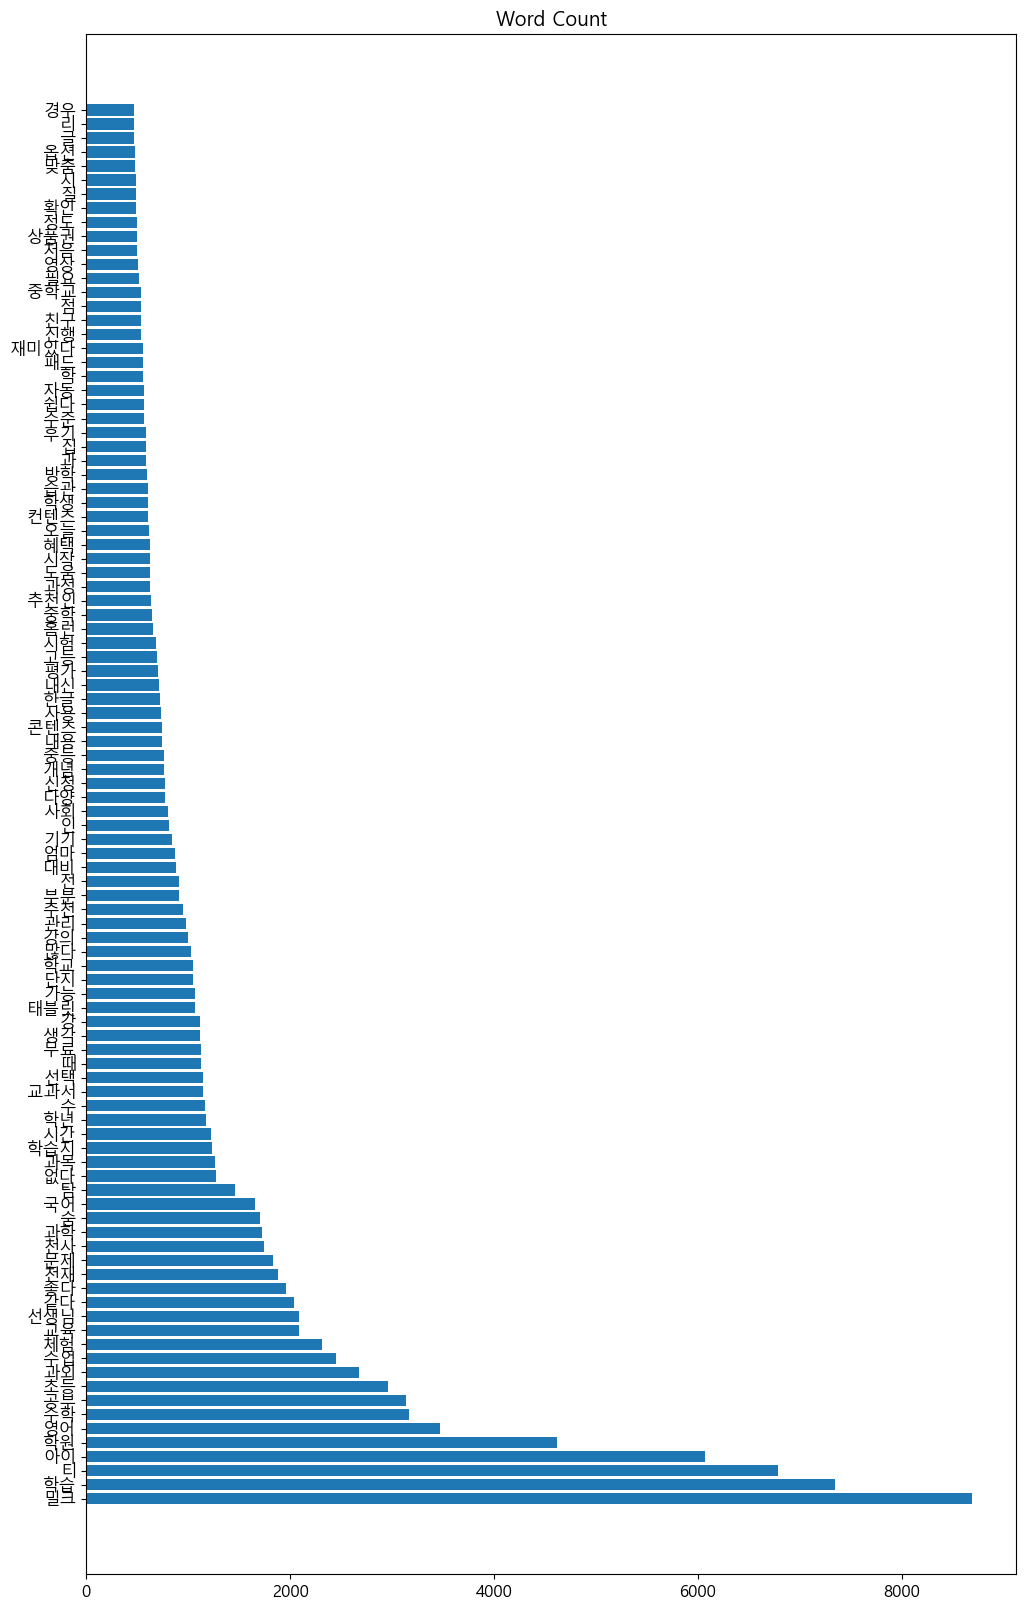

In [53]:
plt.rcParams['font.size'] = 12

y_pos = np.arange(len(top_milk_nouns))

plt.figure(figsize=(12, 20))
plt.barh(y_pos, top_milk_nouns.values())
plt.title('Word Count')
plt.yticks(y_pos, top_milk_nouns.keys())
plt.show()

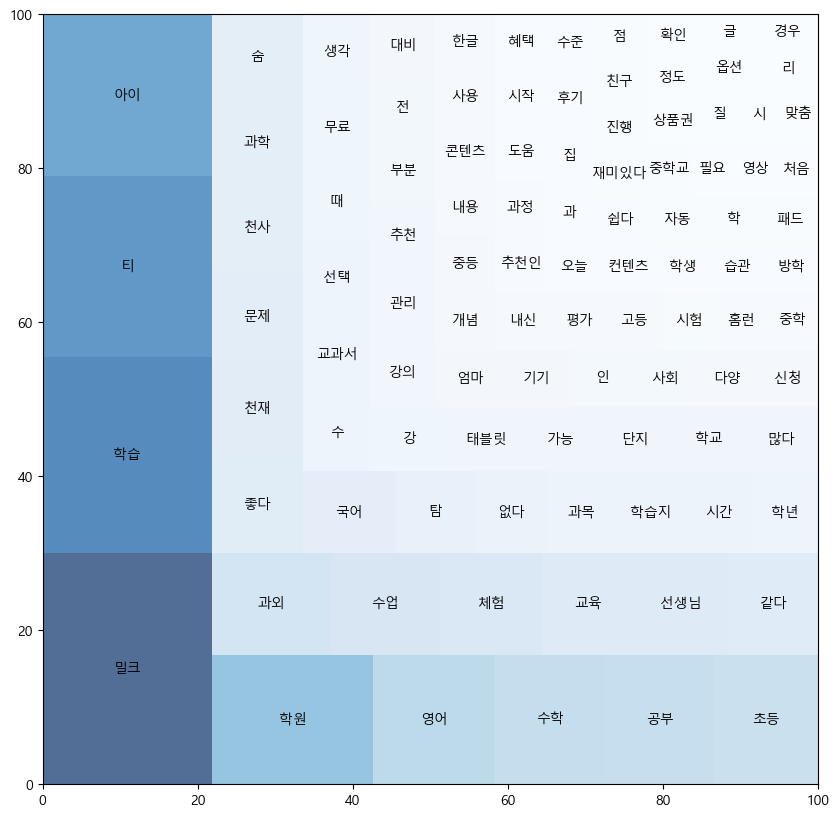

In [54]:
plt.rcParams['figure.figsize'] = (10, 10)
plt.rcParams['font.size'] = 10

norm = mpl.colors.Normalize(vmin = min(top_milk_nouns.values()),
                            vmax = max(top_milk_nouns.values()))

colors = [mpl.cm.Blues(norm(value)) for value in top_milk_nouns.values()]

squarify.plot(label=top_milk_nouns.keys(),
              sizes=top_milk_nouns.values(),
              color=colors,
              alpha=.7);

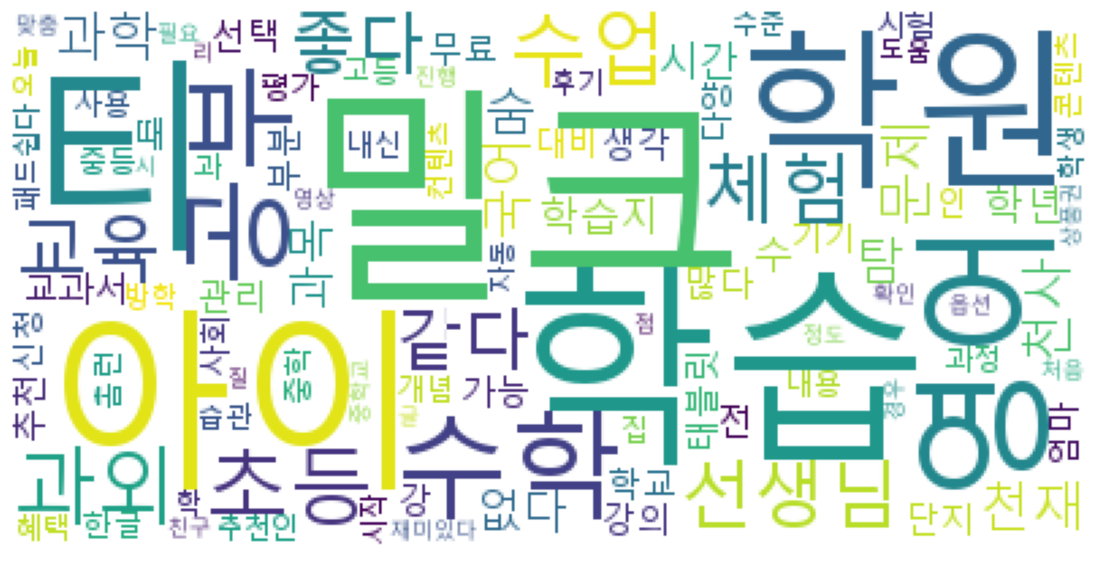

In [55]:
wc = WordCloud(background_color='white', font_path='C:/Windows/Fonts/malgun.ttf')
wc.generate_from_frequencies(top_milk_nouns)

figure = plt.figure(figsize = (14,14))
ax = figure.add_subplot(1,1,1)
ax.axis('off')
ax.imshow(wc)
plt.show()